# IMPLEMENTATION OF CLUSTERING ON AIRLINES DATA USING PCA AND K-MEANS ALGORITHM IN AMAZON SAGEMAKER

In [1]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
#Load the libraries
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gzip, csv

In [3]:
#Giving permission to the notebook to access Amazon S3 bucket
from sagemaker import get_execution_role

role = get_execution_role()
role

'arn:aws:iam::168463519729:role/LabRole'

In [4]:
#Loading the dataset
#The data is perviously downloaded and stored in a public S3 bucket. The Python SDK is used to interact with AWS using a Boto3 client.
s3_client = boto3.client("s3")
data_bucket_name = "amlpcakmeans"

In [5]:
#To get a list of objects that are contained within the bucket
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['EastWestAirlines.csv']


In [6]:
file_data = file[0]

In [7]:
#Transfer the data from the CSV file in the bucket.
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
airlines = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [8]:
#To print the first 5 rows in the dataset
airlines.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


## Step 2: Exploratory data analysis *EDA* - Data cleaning and exploration
### a. Cleaning the data
We can do simple data cleaning and processing right in our notebook instance, using `the compute` instance of the notebook to execute these computations.

How much data are we working with?

There are 3999 rows with 12 columns

In [9]:
#Returns the no.of rows and columns in the dataset
airlines.shape

(3999, 12)

In [10]:
#To find whether there are any existing null values or not
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID                 3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award              3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


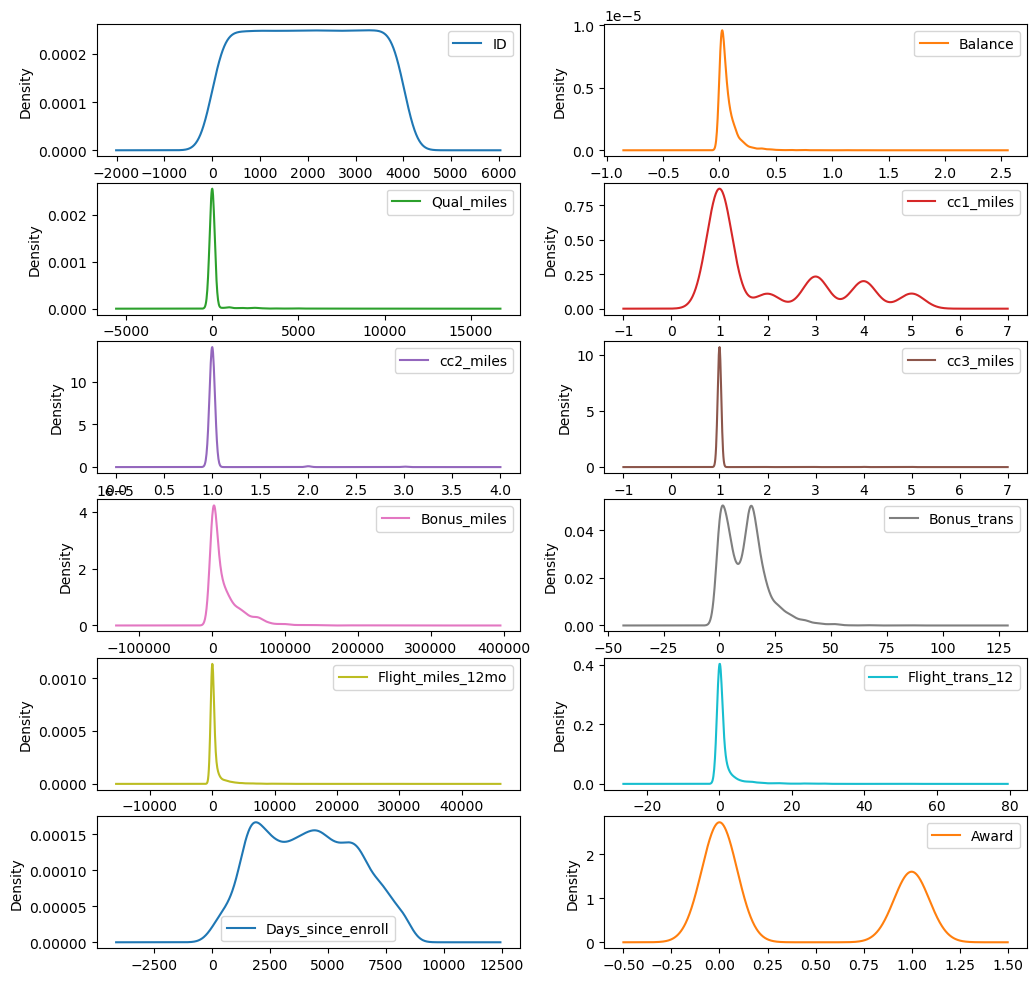

In [11]:
#Density Plot
airlines.plot(kind='density',subplots=True,layout=(6,2),figsize=(12,12),sharex=False)
plt.show()

In [12]:
#Count of duplicated rows
airlines[airlines.duplicated()]

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award


<Axes: >

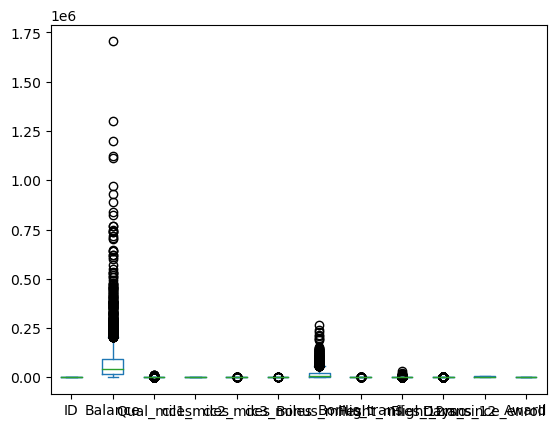

In [13]:
#Built a box plot for all the columns for Outlier Detection
airlines.plot(kind='box')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc74e077130>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc74e077670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc74e076e90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc74e077bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc74e077e50>],
 'means': []}

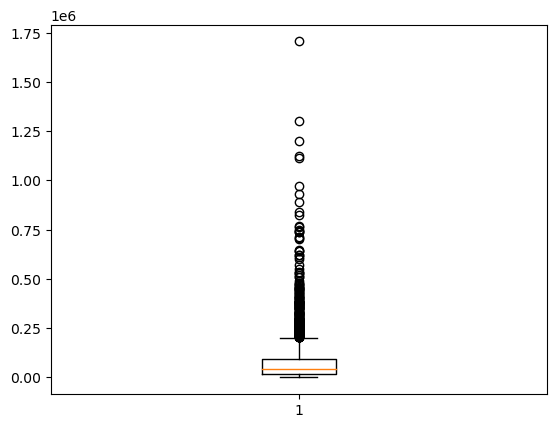

In [14]:
#Built a box plot for particular column for Outlier Detection
plt.boxplot(airlines['Balance'])

In [15]:
#Returns stats of a particular column
airlines.Balance.describe()

count    3.999000e+03
mean     7.360133e+04
std      1.007757e+05
min      0.000000e+00
25%      1.852750e+04
50%      4.309700e+04
75%      9.240400e+04
max      1.704838e+06
Name: Balance, dtype: float64

In [16]:
#Calculation of IQR 
IQR = 9.240400e+04 - 1.852750e+04
IQR

73876.5

In [17]:
#Calculation of upper fence
upper_fence = 9.240400e+04 + (1.5*IQR)
upper_fence

203218.75

In [18]:
#Drop the outliers
index=airlines[airlines.Balance>203218.75].index
airlines = airlines.drop(index,axis=0)

<Axes: >

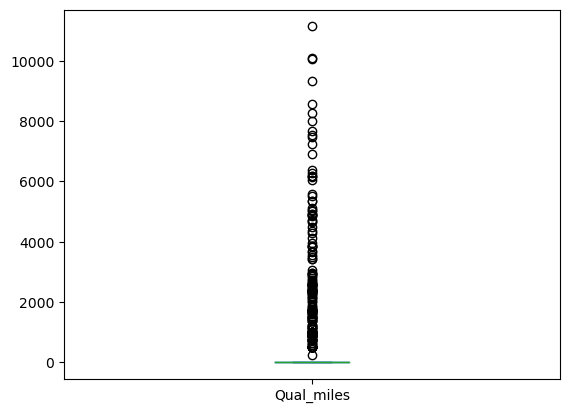

In [19]:
airlines.Qual_miles.plot(kind='box')

<Axes: >

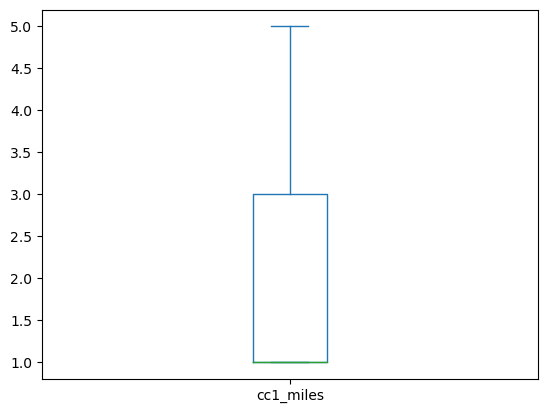

In [20]:
airlines.cc1_miles.plot(kind='box')

<Axes: >

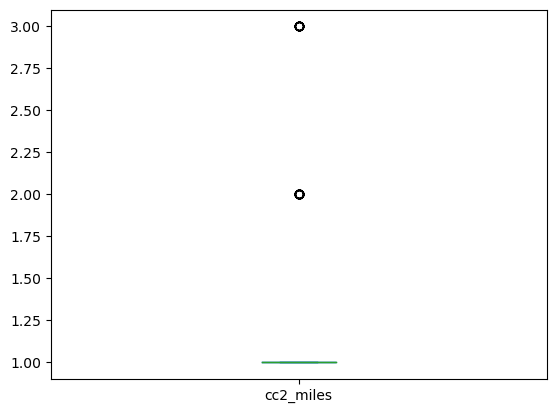

In [21]:
airlines.cc2_miles.plot(kind='box')

<Axes: >

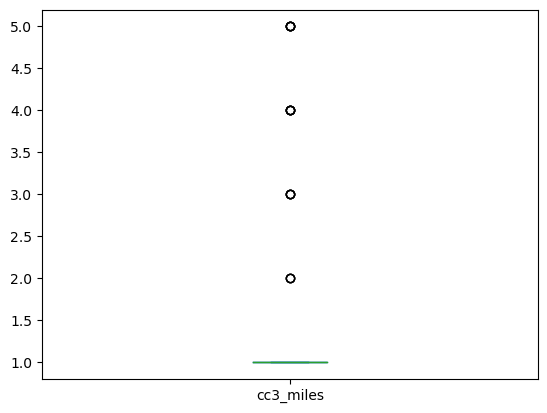

In [22]:
airlines.cc3_miles.plot(kind='box')

<Axes: >

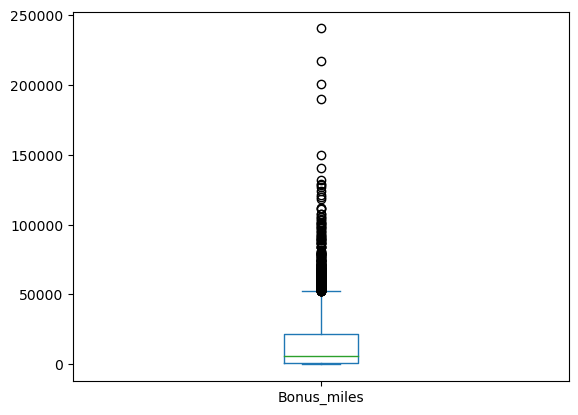

In [23]:
airlines.Bonus_miles.plot(kind='box')

In [24]:
airlines.Bonus_miles.describe()

count      3733.000000
mean      15328.525047
std       21336.284431
min           0.000000
25%        1100.000000
50%        6250.000000
75%       21559.000000
max      240544.000000
Name: Bonus_miles, dtype: float64

In [25]:
IQR = 21559.000000 - 1100.000000
IQR

20459.0

In [26]:
#Calculation of upper fence
upper_fence = 21559.000000 + (1.5*IQR)
upper_fence

52247.5

In [27]:
index=airlines[airlines.Bonus_miles>52247.5].index
airlines = airlines.drop(index,axis=0)

<Axes: >

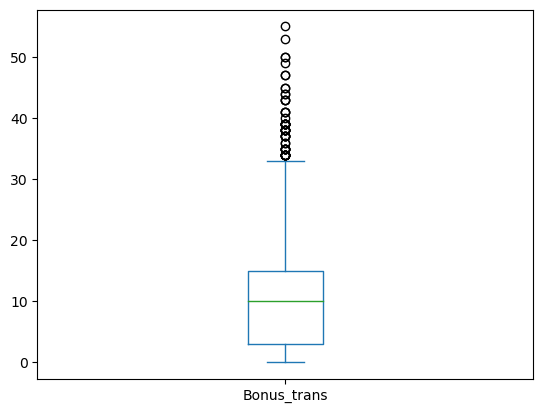

In [28]:
airlines.Bonus_trans.plot(kind='box')

In [29]:
airlines.Bonus_trans.describe()

count    3473.000000
mean       10.149726
std         8.460911
min         0.000000
25%         3.000000
50%        10.000000
75%        15.000000
max        55.000000
Name: Bonus_trans, dtype: float64

In [30]:
IQR = 15.000000 - 3.000000
IQR

12.0

In [31]:
#Calculation of upper fence
upper_fence = 15.000000 + (1.5*IQR)
upper_fence

33.0

In [32]:
index=airlines[airlines.Bonus_trans>33.0].index
airlines = airlines.drop(index,axis=0)

<Axes: >

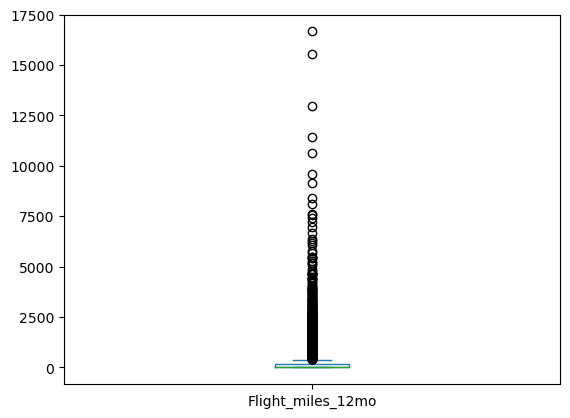

In [33]:
airlines.Flight_miles_12mo.plot(kind='box')

<Axes: >

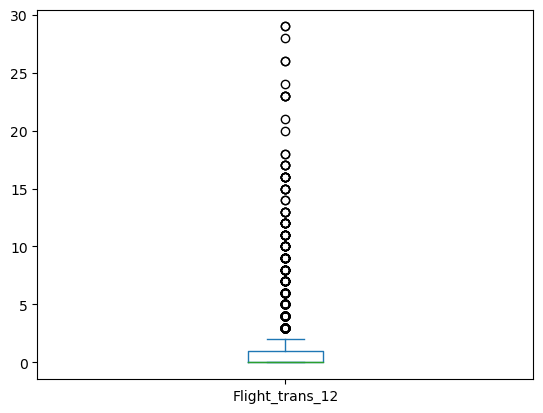

In [34]:
airlines.Flight_trans_12.plot(kind='box')

In [35]:
airlines.Flight_trans_12.describe()

count    3417.000000
mean        0.950541
std         2.601040
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        29.000000
Name: Flight_trans_12, dtype: float64

In [36]:
IQR =  1.000000 -  0.000000
IQR

1.0

In [37]:
#Calculation of upper fence
upper_fence =  1.000000 + (1.5*IQR)
upper_fence

2.5

In [38]:
index=airlines[airlines.Bonus_trans>2.5].index
airlines = airlines.drop(index,axis=0)

<Axes: >

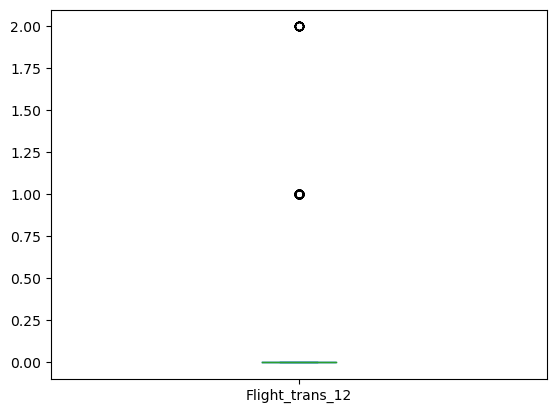

In [39]:
airlines.Flight_trans_12.plot(kind='box')

<Axes: >

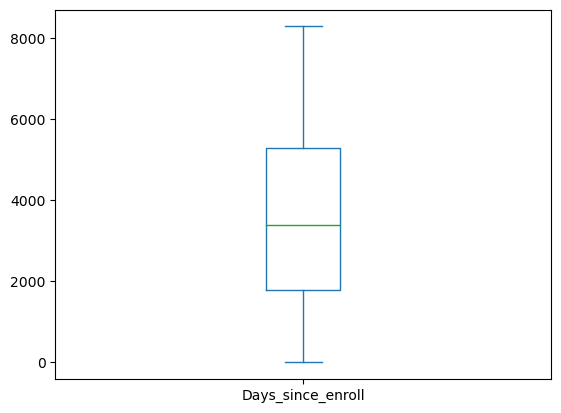

In [40]:
airlines.Days_since_enroll.plot(kind='box')

### b. Visualizing the data
Now we have a dataset with a mix of numerical and categorical columns. We can visualize the data for some of our numerical columns and see what the distribution looks like.

In [41]:
#Prints all the column names in the dataset
airlines.columns

Index(['ID', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


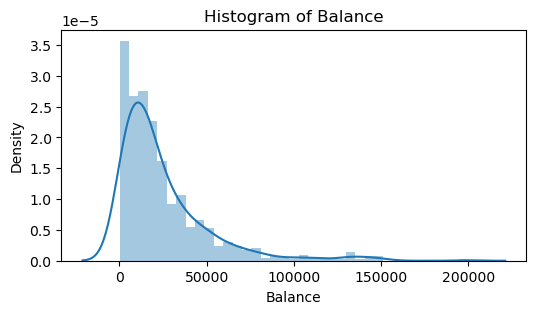

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


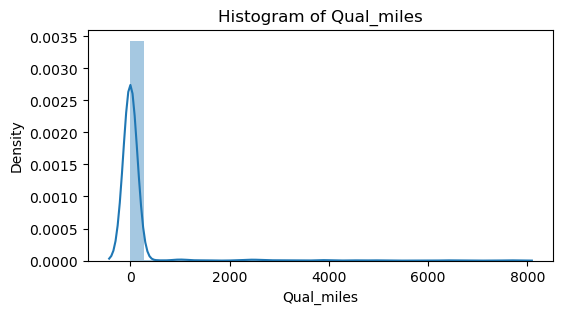

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


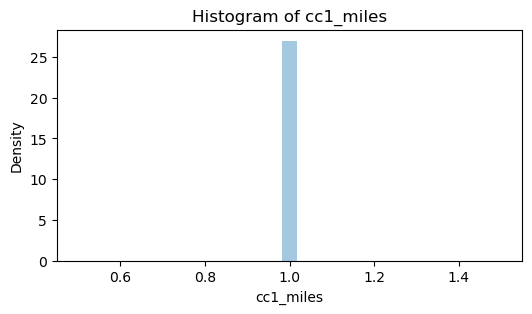

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


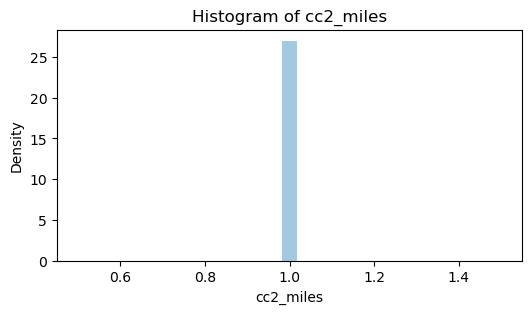

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


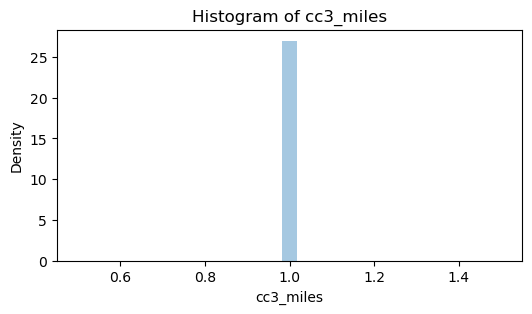

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


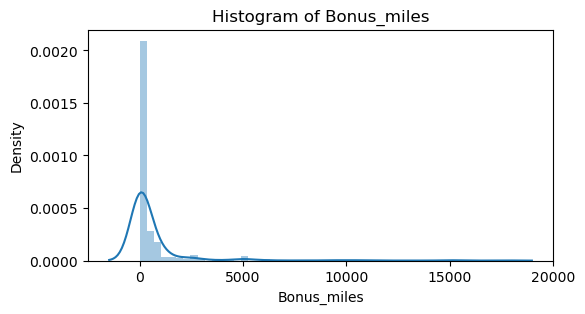

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


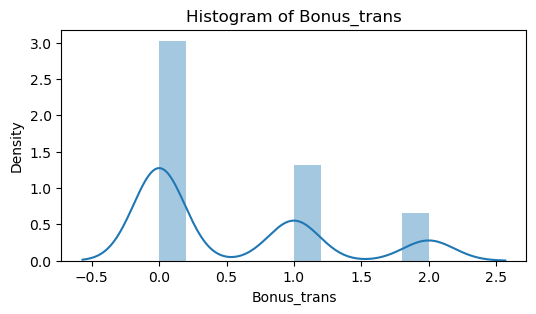

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


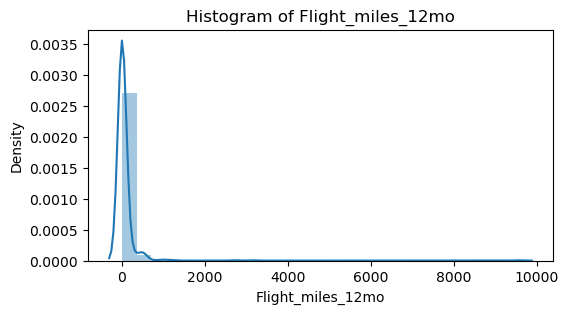

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


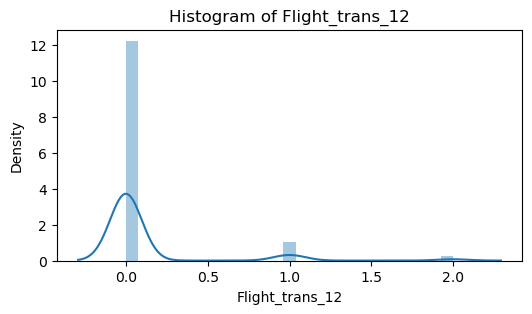

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


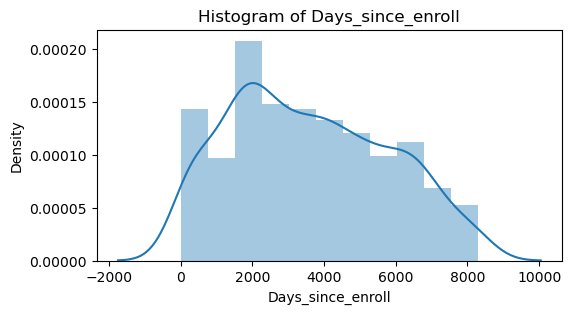

/tmp/ipykernel_28174/1007168061.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(airlines[a])


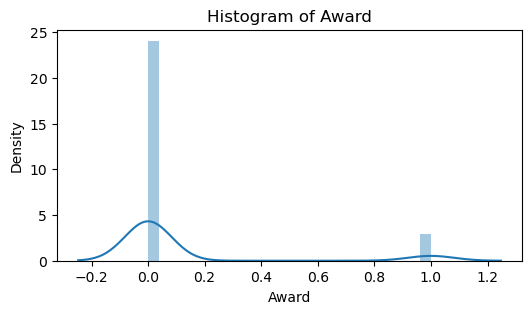

In [42]:
#Plotting Histogram for all the columns in the dataset
import seaborn as sns

for a in ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award']:
    ax = plt.subplots(figsize=(6, 3))
    ax = sns.distplot(airlines[a])
    title = "Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

In [43]:
#Drop the column ID as it doesn't contribute to the model
airlines = airlines.drop('ID', axis=1)

### c. Feature engineering

**Data Scaling**- We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. We can use `minmaxscaler` to transform the numerical columns so that they also fall between 0 and 1.

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
airlines_scaled = pd.DataFrame(scaler.fit_transform(airlines))
airlines_scaled.columns = airlines.columns
airlines_scaled.index = airlines.index

In [45]:
airlines_scaled.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,778.000000,778.000000,778.0,778.0,778.0,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000
mean,0.124168,0.009435,0.0,0.0,0.0,0.034347,0.263496,0.005368,0.055913,0.433778,0.109254
std,0.134017,0.070068,0.0,0.0,0.0,0.106858,0.358718,0.040992,0.184041,0.265953,0.312159
min,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038386,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.215336,0.000000
50%,0.083287,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.409151,0.000000
75%,0.164162,0.000000,0.0,0.0,0.0,0.028571,0.500000,0.000000,0.000000,0.636665,0.000000
max,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
#To find correlation between the variables
airlines.corr()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
Balance,1.000000,0.008973,NaN,NaN,NaN,0.110935,0.091482,0.087818,0.125763,0.176427,0.104898
Qual_miles,0.008973,1.000000,NaN,NaN,NaN,-0.023027,-0.055117,-0.015782,-0.020962,-0.025202,-0.018946
cc1_miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc2_miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc3_miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bonus_miles,0.110935,-0.023027,NaN,NaN,NaN,1.000000,0.431942,0.198926,0.044329,0.006624,0.188007
Bonus_trans,0.091482,-0.055117,NaN,NaN,NaN,0.431942,1.000000,0.198088,0.410123,0.066839,0.093129
Flight_miles_12mo,0.087818,-0.015782,NaN,NaN,NaN,0.198926,0.198088,1.000000,0.412632,-0.023863,-0.001786
Flight_trans_12,0.125763,-0.020962,NaN,NaN,NaN,0.044329,0.410123,0.412632,1.000000,0.022112,0.016744
Days_since_enroll,0.176427,-0.025202,NaN,NaN,NaN,0.006624,0.066839,-0.023863,0.022112,1.000000,0.102347


## Step 3: Data modelling
### a. Dimensionality reduction

We will be using principal component analysis (PCA) to reduce the dimensionality of our data. This method decomposes the data matrix into features that are orthogonal with each other. The resultant orthogonal features are linear combinations of the original feature set.

We can reduce dimensionality with the built-in Amazon SageMaker algorithm for PCA.

Amazon SageMaker Python SDK is used to upload the data to a default bucket. 

In [47]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [48]:
from sagemaker import PCA

num_components = 10

pca_SM = PCA(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://" + bucket + "/airlines/",
    num_components=num_components,
)

In [49]:
#Preparation of data for Amazon SageMaker by extracting the 
# numpy array from the DataFrame and explicitly casting to float32
train_data = airlines_scaled.values.astype("float32")

In [50]:
train_data.shape

(778, 11)

The record_set function in the Amazon SageMaker PCA model converts a numpy array into a record set format that is the required format for the input data to be trained. This is a requirement for all Amazon SageMaker built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, for larger data sets compared with other implementations of the same models, such as the sklearn implementation.

We call the fit function on our PCA model, passing in our training data, and this spins up a training instance or cluster to perform the training job.

In [51]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pca-2023-08-02-03-59-14-172


2023-08-02 03:59:14 Starting - Starting the training job...
2023-08-02 03:59:30 Starting - Preparing the instances for training......
2023-08-02 04:00:44 Downloading - Downloading input data...
2023-08-02 04:01:14 Training - Downloading the training image.........
2023-08-02 04:02:45 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:02:42 INFO 139931619448640] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[08/02/2023 04:02:42 INFO 139931619448640] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '11', 'mini_batch_size': '500', 'num_components': '10'}
[0

### b. Accessing the PCA model attributes

After the model is created, we can also access the underlying model parameters.

Model artifacts are stored in Amazon S3 after they have been trained. This is the same model artifact that is used to deploy a trained model using Amazon SageMaker. Since many of the Amazon SageMaker algorithms use MXNet for computational speed, the model artifact is stored as an ND array. For an output path that was specified during the training call, the model resides in `<training_job_name>/output/model.tar.gz` file, which is a TAR archive file compressed with GNU zip (`gzip`) compression.

In [52]:
job_name = pca_SM.latest_training_job.name
model_key = "airlines/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

model_algo-1


0

In [53]:
#After the model is decompressed, we can load the ND array using MXNet
import mxnet as mx

pca_model_params = mx.ndarray.load("model_algo-1")
pca_model_params

{'s': 
 [4.5639705e-08 6.3290450e-08 1.0069678e+00 1.9489313e+00 2.5518749e+00
  3.6114552e+00 4.6416392e+00 7.3005872e+00 8.6706161e+00 1.0513342e+01]
 <NDArray 10 @cpu(0)>,
 'v': 
 [[ 2.96336065e-17  2.99343495e-17  6.88442495e-03 -1.44899264e-02
    1.36253342e-01  9.68621492e-01  1.70857042e-01  8.95974115e-02
   -5.13991155e-02 -5.55730909e-02]
  [-8.03032696e-17  8.51667170e-16 -5.93047077e-03  9.99781728e-01
   -1.41125533e-03  1.54016251e-02  4.80356906e-03 -4.01569018e-03
    8.76546430e-04  1.10546239e-02]
  [-5.79832494e-01  7.96882868e-01 -3.60822483e-16 -1.05471187e-15
   -2.77555756e-16  6.93889390e-18  0.00000000e+00  2.22044605e-16
    2.77555756e-17  0.00000000e+00]
  [ 1.60771683e-01 -9.21890363e-02 -1.52655666e-16  2.49800181e-16
   -4.44089210e-16  8.32667268e-17 -3.33066907e-16  5.55111512e-17
    0.00000000e+00  0.00000000e+00]
  [ 7.98715651e-01  5.97058535e-01 -2.35922393e-16 -5.96744876e-16
   -9.43689571e-16  9.71445147e-17 -1.11022302e-16 -1.11022302e-16
    

**Three groups of model parameters are contained within the PCA model.**

mean is optional and is only available if the “subtract_mean” hyperparameter is true when calling the training step from the original PCA SageMaker function.

v contains the principal components (same as ‘components_’ in the sklearn PCA model).

s the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

explained-variance-ratio ~= square(s) / sum(square(s))

To calculate the exact explained-variance-ratio vector if needed, it simply requires saving the sum of squares of the original data (call that N) and computing explained-variance-ratio = square(s) / N.

In [54]:
s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())

In [55]:
v

,0,1,2,3,4,5,6,7,8,9
0,2.963361e-17,2.993435e-17,6.884425e-03,-1.448993e-02,1.362533e-01,9.686215e-01,1.708570e-01,8.959741e-02,-5.139912e-02,-5.557309e-02
1,-8.030327e-17,8.516672e-16,-5.930471e-03,9.997817e-01,-1.411255e-03,1.540163e-02,4.803569e-03,-4.015690e-03,8.765464e-04,1.105462e-02
2,-5.798325e-01,7.968829e-01,-3.608225e-16,-1.054712e-15,-2.775558e-16,6.938894e-18,0.000000e+00,2.220446e-16,2.775558e-17,0.000000e+00
3,1.607717e-01,-9.218904e-02,-1.526557e-16,2.498002e-16,-4.440892e-16,8.326673e-17,-3.330669e-16,5.551115e-17,0.000000e+00,0.000000e+00
4,7.987157e-01,5.970585e-01,-2.359224e-16,-5.967449e-16,-9.436896e-16,9.714451e-17,-1.110223e-16,-1.110223e-16,0.000000e+00,1.387779e-17
5,-6.886829e-16,-4.790181e-16,9.749525e-02,-1.129730e-03,-9.599755e-01,1.575903e-01,-1.589668e-01,-3.780780e-02,-1.410896e-02,-1.311750e-01
6,1.596218e-16,1.422777e-16,-1.102587e-02,1.119875e-02,1.587895e-01,-1.362846e-02,-2.372802e-01,-4.709829e-02,2.785320e-01,-9.155616e-01
7,-5.541981e-17,-6.816802e-16,-9.899830e-01,-6.301644e-03,-1.097147e-01,7.388329e-03,8.363692e-02,-5.885254e-03,1.228398e-02,-2.492907e-02
8,-4.402713e-17,-2.059742e-17,1.008183e-01,7.536213e-04,-1.394600e-01,-1.541783e-01,9.386695e-01,-7.825929e-03,9.952897e-02,-2.356848e-01
9,7.728038e-17,-3.419810e-17,-4.418681e-03,6.966882e-03,-3.150383e-02,-1.006052e-01,-1.776281e-02,9.567259e-01,-2.414891e-01,-1.219060e-01


In [56]:
s

,0
0,4.563971e-08
1,6.329045e-08
2,1.006968e+00
3,1.948931e+00
4,2.551875e+00
5,3.611455e+00
6,4.641639e+00
7,7.300587e+00
8,8.670616e+00
9,1.051334e+01


Calculation of variance explained by the largest n components that we want to keep. In this scenario, we can see that the largest 3 components explain ~83% of the total variance in our dataset:

In [57]:
s.iloc[7:, :].apply(lambda x: x * x).sum() / s.apply(lambda x: x * x).sum()

0    0.838861
dtype: float32

In [58]:
v_5 = v.iloc[:, 7:]
v_5

,7,8,9
0,8.959741e-02,-5.139912e-02,-5.557309e-02
1,-4.015690e-03,8.765464e-04,1.105462e-02
2,2.220446e-16,2.775558e-17,0.000000e+00
3,5.551115e-17,0.000000e+00,0.000000e+00
4,-1.110223e-16,0.000000e+00,1.387779e-17
5,-3.780780e-02,-1.410896e-02,-1.311750e-01
6,-4.709829e-02,2.785320e-01,-9.155616e-01
7,-5.885254e-03,1.228398e-02,-2.492907e-02
8,-7.825929e-03,9.952897e-02,-2.356848e-01
9,9.567259e-01,-2.414891e-01,-1.219060e-01


In [59]:
#After we have decided to keep the top 3 components
#we can take only the 3 largest components from our original s and v matrix.
s_5 = s.iloc[7:, :]
v_5 = v.iloc[:, 7:]
v_5.columns = [0,1,2]

In [60]:
v_5

,0,1,2
0,8.959741e-02,-5.139912e-02,-5.557309e-02
1,-4.015690e-03,8.765464e-04,1.105462e-02
2,2.220446e-16,2.775558e-17,0.000000e+00
3,5.551115e-17,0.000000e+00,0.000000e+00
4,-1.110223e-16,0.000000e+00,1.387779e-17
5,-3.780780e-02,-1.410896e-02,-1.311750e-01
6,-4.709829e-02,2.785320e-01,-9.155616e-01
7,-5.885254e-03,1.228398e-02,-2.492907e-02
8,-7.825929e-03,9.952897e-02,-2.356848e-01
9,9.567259e-01,-2.414891e-01,-1.219060e-01


We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. For example, the following code shows the first component. We can see that this component describes a passenger who has high Bonus Transactions, Award and Flight transactions in the last 12 months.

Note that this is v_5[2] or last component of the list of components in v_5, but is actually the largest component because the components are ordered from smallest to largest. So v_5[0] would be the smallest component. Similarly, change the value of component_num to cycle through the makeup of each component.

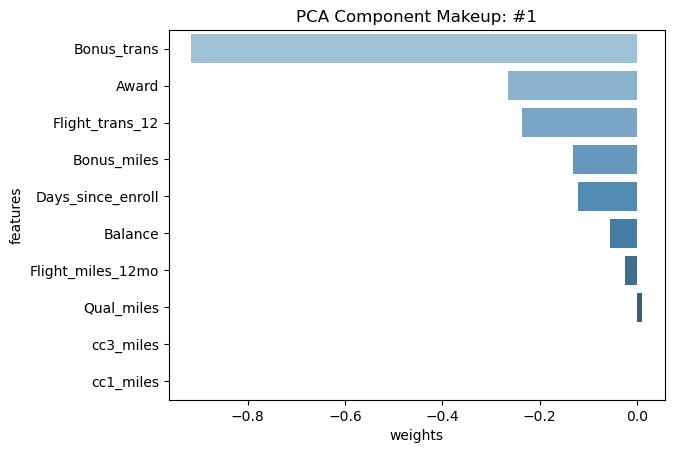

In [61]:
component_num = 1

first_comp = v_5[3 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, airlines_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

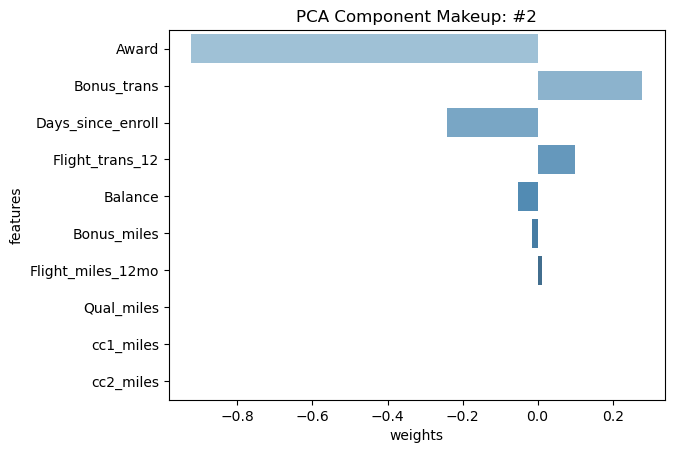

In [62]:
component_num = 2

second_comp = v_5[3 - component_num]
comps = pd.DataFrame(
    list(zip(second_comp, airlines_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

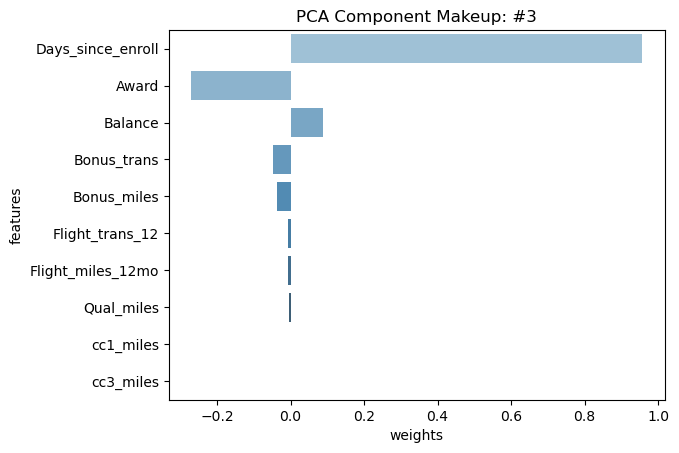

In [63]:
component_num = 3

third_comp = v_5[3 - component_num]
comps = pd.DataFrame(
    list(zip(third_comp, airlines_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [64]:
PCA_list = ["comp_1", "comp_2", "comp_3"]

### c. Deploying the PCA model

We can now deploy this model endpoint and use it to make predictions. This model is now live and hosted on an instance_type that we specify.

In [65]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: pca-2023-08-02-04-03-52-690
INFO:sagemaker:Creating endpoint-config with name pca-2023-08-02-04-03-52-690
INFO:sagemaker:Creating endpoint with name pca-2023-08-02-04-03-52-690


--------!CPU times: user 128 ms, sys: 13.1 ms, total: 142 ms
Wall time: 4min 32s


We can also pass our original dataset to the model so that we can transform the data using the model we created. Then we can take the largest 3 components and this will reduce the dimensionality of our data from 11 to 3.

In [66]:
%%time
result = pca_predictor.predict(train_data)

CPU times: user 59.1 ms, sys: 0 ns, total: 59.1 ms
Wall time: 191 ms


In [67]:
airlines_transformed = pd.DataFrame()
for a in result:
    b = a.label["projection"].float32_tensor.values
    airlines_transformed = pd.concat([airlines_transformed, pd.DataFrame([list(b)])])
airlines_transformed.index = airlines_scaled.index
airlines_transformed = airlines_transformed.iloc[:, 7:]
airlines_transformed.columns = PCA_list

Now we have created a dataset where each observation is described by the 3 principal components that we analyzed earlier. Each of these 3 components is a linear combination of the original feature space. We can interpret each of these 3 components by analyzing the makeup of the component shown previously.

In [68]:
airlines_transformed

,comp_1,comp_2,comp_3
0,0.413477,0.061535,-0.222044
1,0.382160,0.203988,-0.677188
3,0.401245,0.066107,-0.220066
5,0.425457,-0.072888,0.241152
14,0.422547,-0.072330,0.241252
...,...,...,...
3981,-0.218075,0.091766,0.326555
3983,-0.231581,0.224462,-0.140433
3990,-0.273019,0.364010,-0.629300
3997,-0.225309,0.267820,-0.268775


# d. Population segmentation using unsupervised clustering

Forming clusters of the passengers using KMeans algorithm with 3 PCA attributes created

In [69]:
train_data = airlines_transformed.values.astype("float32")

Finding the optimum number of clusters for KMeans Clustering

In [70]:
from time import gmtime, strftime
from sagemaker import KMeans
output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'KMeans-optimal-results' + output_time
K = range(2, 8) # change the range to be used for k
job_names = []
# launching jobs for all k
for k in K:
    print('starting train job for cluster with k:' + str(k))
    output_location = 's3://{}/kmeans_optimal/'.format(bucket) + output_folder
    print('training artifacts will be uploaded to: {}'.format(output_location))
    job_name = 'final-' + str(k) + output_time
    
    kmeans = KMeans(role=role, instance_count=1, instance_type='ml.m4.xlarge',
                output_path=output_location, k=k, epochs=3) 
    kmeans.fit(kmeans.record_set(train_data), job_name=job_name)
    job_names.append(job_name)
    print('end of train job for cluster: ' + str(k))

starting train job for cluster with k:2
training artifacts will be uploaded to: s3://sagemaker-us-east-1-168463519729/kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-22023-08-02-04-09-22


2023-08-02 04:09:22 Starting - Starting the training job...
2023-08-02 04:09:46 Starting - Preparing the instances for training.........
2023-08-02 04:11:02 Downloading - Downloading input data...
2023-08-02 04:11:27 Training - Downloading the training image......
2023-08-02 04:12:43 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:12:59 INFO 139727514474304] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-32023-08-02-04-09-22


2023-08-02 04:13:36 Starting - Starting the training job...
2023-08-02 04:14:03 Starting - Preparing the instances for training.........
2023-08-02 04:15:17 Downloading - Downloading input data...
2023-08-02 04:15:47 Training - Downloading the training image......
2023-08-02 04:16:58 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:17:14 INFO 139964467226432] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-42023-08-02-04-09-22


2023-08-02 04:17:50 Starting - Starting the training job...
2023-08-02 04:18:14 Starting - Preparing the instances for training.........
2023-08-02 04:19:47 Downloading - Downloading input data
2023-08-02 04:19:47 Training - Downloading the training image.........
2023-08-02 04:20:57 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:21:14 INFO 140335188363072] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto'

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-52023-08-02-04-09-22


2023-08-02 04:22:34 Starting - Starting the training job......
2023-08-02 04:23:10 Starting - Preparing the instances for training......
2023-08-02 04:24:28 Downloading - Downloading input data...
2023-08-02 04:24:53 Training - Downloading the training image.........
2023-08-02 04:26:34 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:26:25 INFO 140183288534848] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'in

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-62023-08-02-04-09-22


2023-08-02 04:27:18 Starting - Starting the training job.........
2023-08-02 04:28:45 Starting - Preparing the instances for training.........
2023-08-02 04:30:20 Downloading - Downloading input data
2023-08-02 04:30:20 Training - Downloading the training image.........
2023-08-02 04:31:35 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:31:52 INFO 140646640215872] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore':

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: final-72023-08-02-04-09-22


2023-08-02 04:32:32 Starting - Starting the training job...
2023-08-02 04:33:02 Starting - Preparing the instances for training.........
2023-08-02 04:34:26 Downloading - Downloading input data...
2023-08-02 04:34:56 Training - Downloading the training image......
2023-08-02 04:36:02 Training - Training image download completed. Training in progress....
2023-08-02 04:36:27 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:36:18 INFO 140358133487424] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wa

Plotting the Elbow Curve to find the optimal number of clusters

Model for k=2 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-22023-08-02-04-09-22/output/model.tar.gz)
model_algo-1
Model for k=3 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-32023-08-02-04-09-22/output/model.tar.gz)
model_algo-1
Model for k=4 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-42023-08-02-04-09-22/output/model.tar.gz)
model_algo-1
Model for k=5 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-52023-08-02-04-09-22/output/model.tar.gz)
model_algo-1
Model for k=6 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-62023-08-02-04-09-22/output/model.tar.gz)
model_algo-1
Model for k=7 (kmeans_optimal/KMeans-optimal-results2023-08-02-04-09-22/final-72023-08-02-04-09-22/output/model.tar.gz)
model_algo-1


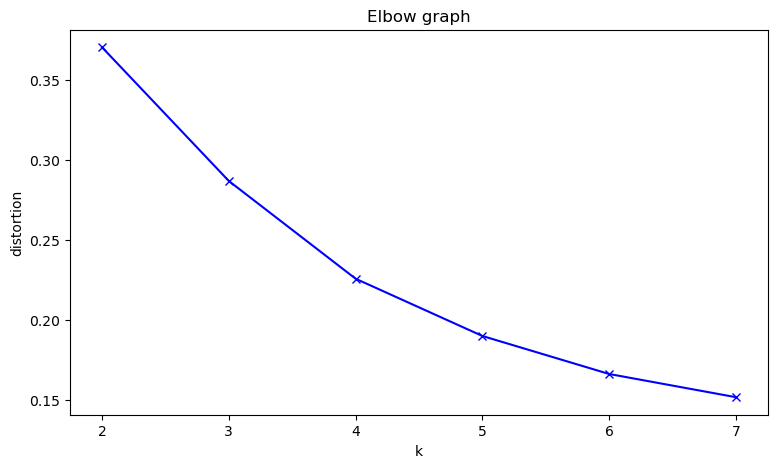

In [71]:
from scipy.spatial.distance import cdist
#plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
for k in K:
    s3_client = boto3.client('s3')
    key = 'kmeans_optimal/' + output_folder +'/'+ 'final-'+ str(k) + output_time +'/output/model.tar.gz'
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(train_data, kmeans_numpy, 'euclidean'), axis=1)) / train_data.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.figure(figsize=(9,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.xticks(np.arange(2, 8))
plt.title('Elbow graph')
plt.show()

First, we call and define the hyperparameters of our KMeans model as we have done with our PCA model. In this scenario, we find the top 3 clusters from our dataset.

In [72]:
from sagemaker import KMeans

num_clusters = 3
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://" + bucket + "/airlines/",
    k=num_clusters,
)

In [73]:
%%time
kmeans.fit(kmeans.record_set(train_data))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2023-08-02-04-37-37-071


2023-08-02 04:37:37 Starting - Starting the training job...
2023-08-02 04:38:01 Starting - Preparing the instances for training.........
2023-08-02 04:39:21 Downloading - Downloading input data...
2023-08-02 04:39:47 Training - Downloading the training image......
2023-08-02 04:40:57 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/02/2023 04:41:14 INFO 139651143960384] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto

In [74]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2023-08-02-04-41-57-365
INFO:sagemaker:Creating endpoint-config with name kmeans-2023-08-02-04-41-57-365
INFO:sagemaker:Creating endpoint with name kmeans-2023-08-02-04-41-57-365


--------!CPU times: user 133 ms, sys: 5.38 ms, total: 138 ms
Wall time: 4min 32s


In [75]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 62.1 ms, sys: 0 ns, total: 62.1 ms
Wall time: 234 ms


We can see the breakdown of cluster counts and the distribution of clusters.

In [76]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [77]:
pd.DataFrame(cluster_labels)[0].value_counts()

0
1.0    435
2.0    258
0.0     85
Name: count, dtype: int64

/tmp/ipykernel_28174/3289919326.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(cluster_labels, kde=False)


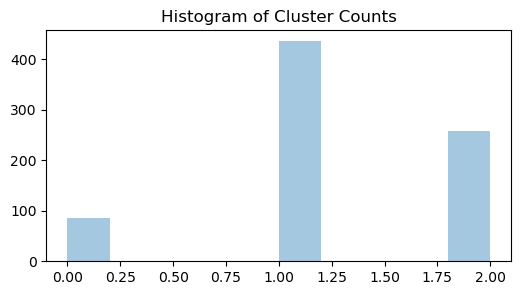

In [78]:
ax = plt.subplots(figsize=(6, 3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

## Step 4: Drawing conclusions from our modelling

Explaining the result of the modelling is an important step in making use of our analysis. By combining `PCA` and `KMeans`, and the information contained in the model attributes within an Amazon SageMaker trained model, we can form concrete conclusions based on the data.

a. Accessing the KMeans model attributes
First, we will go into the bucket where the KMeans model is stored and extract it.

In [79]:
job_name = kmeans.latest_training_job.name
model_key = "airlines/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

model_algo-1


0

In [80]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

In [81]:
airlines_scaled.columns

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

There is 1 set of model parameters that is contained within the KMeans model.

Cluster Centroid Locations: The location of the centers of each cluster identified by the KMeans algorithm. The cluster location is given in our PCA transformed space with 5 components, since we passed the transformed PCA data into the model.

In [82]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = airlines_transformed.columns

In [83]:
cluster_centroids

,comp_1,comp_2,comp_3
0,-0.170647,-0.815429,-0.344437
1,0.015884,0.029672,0.292228
2,0.025722,0.219099,-0.376664


We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the PCA components that we interpreted previously.

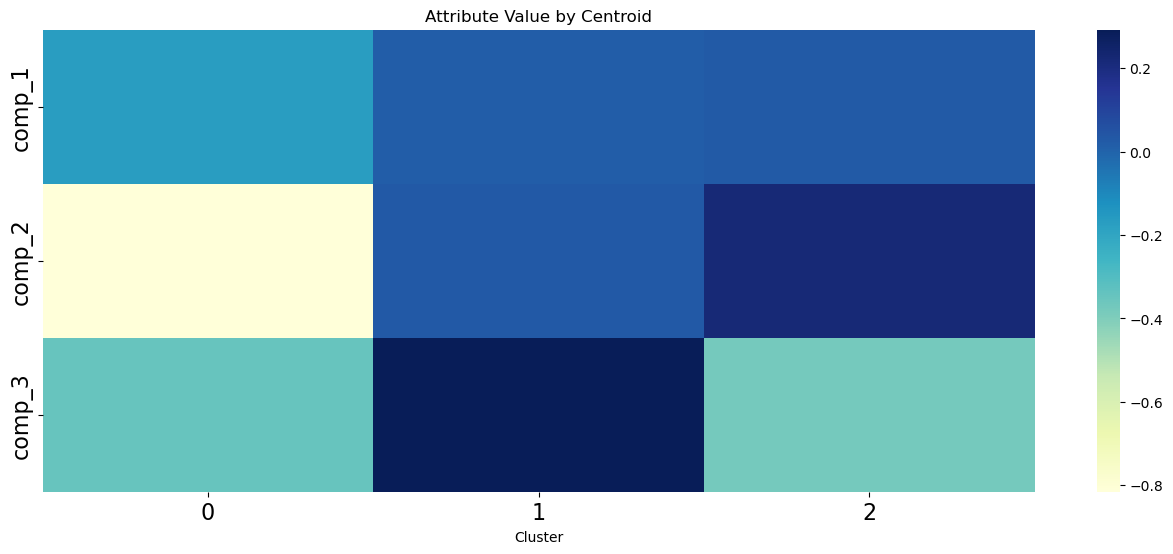

In [84]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

We can also map the cluster labels back to each individual county and examine which counties were naturally grouped together.

In [85]:
airlines_transformed["labels"] = list(map(int, cluster_labels))
airlines_transformed.head()

,comp_1,comp_2,comp_3,labels
0,0.413477,0.061535,-0.222044,2
1,0.382160,0.203988,-0.677188,2
3,0.401245,0.066107,-0.220066,2
5,0.425457,-0.072888,0.241152,1
14,0.422547,-0.072330,0.241252,1


In [86]:
airlines["labels"] = list(map(int, cluster_labels))
airlines.head(20)

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,labels
0,28143,0,1,1,1,174,1,0,0,7000,0,2
1,19244,0,1,1,1,215,2,0,0,6968,0,2
3,14776,0,1,1,1,500,1,0,0,6952,0,2
5,16420,0,1,1,1,0,0,0,0,6942,0,1
14,17648,0,1,1,1,0,0,0,0,6912,0,1
26,18521,0,1,1,1,1227,2,1227,2,7917,0,2
27,8828,0,1,1,1,0,0,0,0,7914,0,1
31,10021,0,1,1,1,0,0,0,0,7879,0,1
33,18047,0,1,1,1,100,1,0,0,7868,0,2
34,43832,0,1,1,1,0,0,0,0,7865,0,1


In [87]:
cluster = airlines.groupby(airlines.labels).mean()
cluster.head(20)

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
labels,,,,,,,,,,,
0,32891.152941,43.270588,1.0,1.0,1.0,1604.294118,0.717647,49.411765,0.129412,4243.952941,1.0
1,22335.990805,99.087356,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,3390.331034,0.0
2,26505.596899,36.693798,1.0,1.0,1.0,1284.000000,1.352713,138.755814,0.294574,3740.612403,0.0


## Inferences
### The Clusters are named according to the Bonus_miles of passengers for the EastWestAirlines to classify which passenger belongs to which tier of membership and so they can offer benefits accordingly.
### Tier 1 Membership - cluster # 0
### Tier 2 Membership - cluster # 2
### Tier 3 Membership - cluster # 1

In [88]:
pca_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pca-2023-08-02-04-03-52-690
INFO:sagemaker:Deleting endpoint with name: pca-2023-08-02-04-03-52-690


In [89]:
kmeans_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: kmeans-2023-08-02-04-41-57-365
INFO:sagemaker:Deleting endpoint with name: kmeans-2023-08-02-04-41-57-365
